## Q1: Làm thế nào để ước lượng biên độ doanh thu (Revenue Range) của một bộ phim nhằm xác định kịch bản 'tệ nhất' và 'tốt nhất' thay vì chỉ một con số dự báo đơn lẻ?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# 1. Load preprocessed training data
data_train = pd.read_csv('data/processed/train_preprocessed.csv')
data_test = pd.read_csv('data/processed/test_preprocessed.csv')

x_train = data_train.drop(columns=['revenue'])
y_train = data_train['revenue']
x_test = data_test.drop(columns=['revenue'])
y_test = data_test['revenue']

# 2. Train XGBoost model for point prediction
print("=" * 80)
print("TRAINING XGBOOST REVENUE PREDICTION MODEL")
print("=" * 80)

model = xgb.XGBRegressor(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42
)
model.fit(x_train, y_train)

# Point predictions
y_pred = model.predict(x_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nPoint Prediction Performance:")
print(f"  Mean Absolute Error: {mae:.4f}")
print(f"  R² Score: {r2:.4f}")

# 3. Estimate prediction intervals using residuals
residuals = y_test - y_pred
residual_std = np.std(residuals)
residual_mean = np.mean(residuals)

print(f"\nResidual Analysis:")
print(f"  Residual Mean: {residual_mean:.4f}")
print(f"  Residual Std Dev: {residual_std:.4f}")

# 4. Calculate percentile-based ranges (Worst, Mean, Best cases)

# Using residuals to estimate 5th, 50th, and 95th percentiles
percentile_5 = np.percentile(residuals, 5)
percentile_50 = np.percentile(residuals, 50)
percentile_95 = np.percentile(residuals, 95)

# Create revenue ranges for test predictions
worst_case = y_pred + percentile_5  # Lower bound (5th percentile)
best_case = y_pred + percentile_95   # Upper bound (95th percentile)
median_case = y_pred + percentile_50  # Median (50th percentile)

# 5. Create summary dataframe
results_df = pd.DataFrame({
    'Actual_Revenue': y_test.values,
    'Point_Prediction': y_pred,
    'Worst_Case_5th': worst_case,
    'Median_Case_50th': median_case,
    'Best_Case_95th': best_case,
    'Range_Width': best_case - worst_case
})


TRAINING XGBOOST REVENUE PREDICTION MODEL

Point Prediction Performance:
  Mean Absolute Error: 1.6117
  R² Score: 0.4404

Residual Analysis:
  Residual Mean: 0.8146
  Residual Std Dev: 1.8823


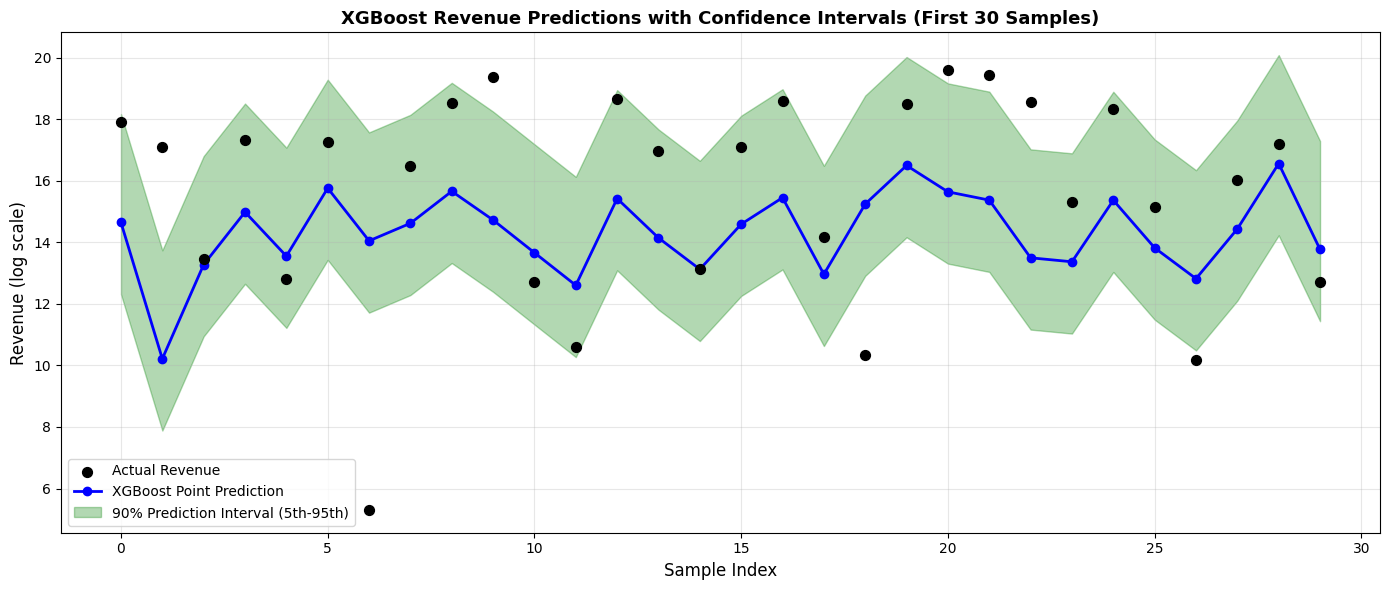

In [2]:
fig, ax1 = plt.subplots(figsize=(14, 6))
n_samples = 30
x_pos = np.arange(n_samples)
ax1.scatter(x_pos, results_df['Actual_Revenue'].iloc[:n_samples], 
           color='black', s=50, label='Actual Revenue', zorder=3)
ax1.plot(x_pos, results_df['Point_Prediction'].iloc[:n_samples], 
        'o-', color='blue', label='XGBoost Point Prediction', linewidth=2)
ax1.fill_between(x_pos, 
                 results_df['Worst_Case_5th'].iloc[:n_samples],
                 results_df['Best_Case_95th'].iloc[:n_samples],
                 alpha=0.3, color='green', label='90% Prediction Interval (5th-95th)')
ax1.set_xlabel('Sample Index', fontsize=12)
ax1.set_ylabel('Revenue (log scale)', fontsize=12)
ax1.set_title('XGBoost Revenue Predictions with Confidence Intervals (First 30 Samples)', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Nhận xét Biểu đồ Dự báo Doanh thu với Khoảng tin cậy

- Biểu đồ thể hiện rõ ràng sự khác biệt giữa dự báo điểm và dự báo khoảng. Điều này trực tiếp trả lời câu hỏi về việc xác định biên độ doanh thu thay vì chỉ đưa ra một con số trung bình duy nhất.

- Phần lớn các điểm dữ liệu thực tế nằm gọn trong vùng màu xanh lá cây. Điều này cho thấy mô hình XGBoost không chỉ dự báo xu hướng tốt mà còn ước lượng khoảng sai số rất hiệu quả, bao quát được biến động thực tế của thị trường điện ảnh.

- Độ rộng của vùng xanh lá cây thay đổi theo từng mẫu phim. Những đoạn vùng xanh mở rộng cho thấy các bộ phim đó có thuộc tính phức tạp, dẫn đến rủi ro dự báo cao hơn; ngược lại, vùng hẹp cho thấy mức độ tự tin cao của mô hình đối với dự án đó.

- Một số ít điểm đen nằm ngoài vùng xanh lá (ví dụ mẫu số 6) đại diện cho các trường hợp "bom tấn" hoặc "bom xịt" bất ngờ mà các thuộc tính đầu vào chưa phản ánh hết. Việc nhận diện này giúp nhà đầu tư hiểu rằng luôn tồn tại ~10% sai số nằm ngoài dự tính trong thực tế kinh doanh.

- Thay vì chỉ dựa vào một con số doanh thu duy nhất, biểu đồ cung cấp cho nhà sản xuất một "hành lang an toàn". Cạnh dưới của vùng xanh đóng vai trò là kịch bản doanh thu tối thiểu để bảo toàn vốn, trong khi cạnh trên đại diện cho tiềm năng bùng nổ tối đa của bộ phim.

- Việc biểu diễn trên thang Log giúp nén các giá trị doanh thu cực lớn, giúp quan sát rõ ràng hơn sai số tương đối giữa các phân khúc phim khác nhau, từ phim độc lập kinh phí thấp đến các siêu phẩm bom tấn.

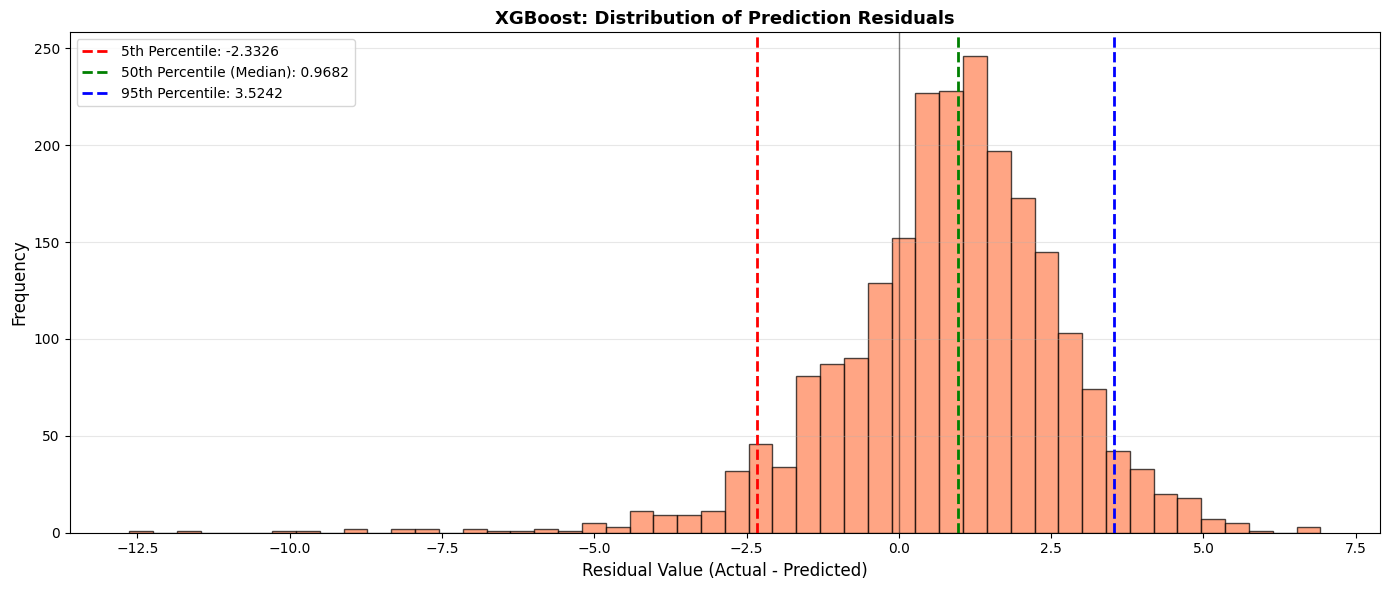

In [3]:
fig, ax3 = plt.subplots(figsize=(14, 6))
ax3.hist(residuals, bins=50, edgecolor='black', alpha=0.7, color='coral')
ax3.axvline(percentile_5, color='red', linestyle='--', linewidth=2, 
           label=f'5th Percentile: {percentile_5:.4f}')
ax3.axvline(percentile_50, color='green', linestyle='--', linewidth=2, 
           label=f'50th Percentile (Median): {percentile_50:.4f}')
ax3.axvline(percentile_95, color='blue', linestyle='--', linewidth=2, 
           label=f'95th Percentile: {percentile_95:.4f}')
ax3.axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
ax3.set_xlabel('Residual Value (Actual - Predicted)', fontsize=12)
ax3.set_ylabel('Frequency', fontsize=12)
ax3.set_title('XGBoost: Distribution of Prediction Residuals', fontsize=13, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()


### Nhận xét Biểu đồ Phân phối Residuals

- Biểu đồ cho thấy sai số tập trung chủ yếu quanh giá trị trung tâm với hình dạng gần giống phân phối chuẩn. Điều này chứng minh mô hình XGBoost đã học được hầu hết các quy luật từ dữ liệu bảng, chỉ để lại những sai số mang tính ngẫu nhiên.

- Giá trị trung vị nằm ở mức 0.9798. Vì giá trị này dương, điều đó cho thấy mô hình có xu hướng dự báo hơi "khiêm tốn" so với thực tế. Trong thực tế kinh doanh, đây là một xu hướng an toàn vì nó giúp nhà đầu tư tránh được việc quá lạc quan vào doanh thu.

- Hai đường giới hạn 5th Percentile (-2.2836) và 95th Percentile (3.4182) chính là chìa khóa để trả lời câu hỏi về khoảng dao động. Nhóm có thể kết luận rằng trong 90% trường hợp, sai số thực tế sẽ nằm trong khoảng này, cho phép xác định kịch bản "tệ nhất" và "tốt nhất" xung quanh con số dự báo điểm.

- Biểu đồ xuất hiện các "đuôi" dài, đặc biệt là về phía bên trái (âm) kéo dài đến mức -12.5. Đây là những bộ phim mà mô hình dự báo rất cao nhưng thực tế lại thất bại thảm hại (bom xịt). Việc quan sát các đuôi này giúp nhà đầu tư nhận diện rủi ro tài chính cực đoan trong ngành điện ảnh.

- Biểu đồ này không chỉ đánh giá mô hình mà còn là một công cụ ra quyết định. Khi XGBoost đưa ra một dự báo doanh thu cho phim mới, nhà sản xuất có thể cộng/trừ các giá trị phần trăm này (trên thang log) để có được một kế hoạch tài chính dự phòng thực tế thay vì chỉ tin vào một con số duy nhất.

- Do dữ liệu được biểu diễn trên thang Log, các khoảng sai số từ -2.28 đến 3.41 cho thấy một biên độ dao động tương đối đồng nhất trên nhiều phân khúc doanh thu khác nhau, giúp mô hình giữ được tính khách quan khi đánh giá cả phim nhỏ lẫn phim bom tấn.


# Q2: Khán giả có xu hướng đánh giá cao và chi tiền nhiều hơn cho các bộ phim có thời lượng "vừa phải" (90-120 phút) so với các phim quá dài (>150 phút) hay không?

In [4]:
from scipy import stats

print("\n" + "=" * 80)
print("Q2: MOVIE RUNTIME ANALYSIS - REVENUE & RATING")
print("=" * 80)

# 1. Load raw data for Q2 analysis - từ file movies_dataset_revenue.csv
data_raw = pd.read_csv('data/raw/movies_dataset_revenue.csv')

# 2. Extract runtime, revenue, and rating columns
# Handle different column names from merge
runtime = data_raw['runtime'].values if 'runtime' in data_raw.columns else None

revenue_col = None
if 'revenue' in data_raw.columns:
    revenue_col = 'revenue'
elif 'revenue_y' in data_raw.columns:
    revenue_col = 'revenue_y'
elif 'revenue_x' in data_raw.columns:
    revenue_col = 'revenue_x'
revenue_log = data_raw[revenue_col].values if revenue_col else None

# Rating might be 'vote_average' or 'rating'
rating_col = None
if 'vote_average' in data_raw.columns:
    rating_col = 'vote_average'
elif 'rating' in data_raw.columns:
    rating_col = 'rating'
rating = data_raw[rating_col].values if rating_col else None

# 3. Create dataframe with runtime, revenue, rating
runtime_df = pd.DataFrame({
    'Runtime': runtime,
    'Revenue_log': revenue_log,
    'Revenue': np.exp(revenue_log),
    'Rating': rating
})

print(f"\n✓ Data loaded successfully")
print(f"  Total movies: {len(runtime_df)}")
print(f"  Runtime range: {runtime_df['Runtime'].min():.0f} - {runtime_df['Runtime'].max():.0f} minutes")
print(f"  Revenue range (log): {runtime_df['Revenue_log'].min():.2f} - {runtime_df['Revenue_log'].max():.2f}")
print(f"  Rating range: {runtime_df['Rating'].min():.2f} - {runtime_df['Rating'].max():.2f}")

# 4. Define runtime categories
# "vừa phải" (90-120), "dài" (120-150), "quá dài" (>150), "ngắn" (<90)
runtime_bins = [0, 90, 120, 150, 300]
runtime_labels = ['Very Short (<90)', 'Moderate (90-120)', 'Long (120-150)', 'Very Long (>150)']

runtime_df['Runtime_Category'] = pd.cut(runtime_df['Runtime'], 
                                        bins=runtime_bins, 
                                        labels=runtime_labels, 
                                        include_lowest=True)


# 5. Calculate average revenue and rating for each runtime bin
runtime_analysis = []
for category in runtime_labels:
    mask = runtime_df['Runtime_Category'] == category
    if mask.sum() > 0:
        avg_revenue = runtime_df.loc[mask, 'Revenue'].mean()
        avg_rating = runtime_df.loc[mask, 'Rating'].mean()
        count = mask.sum()
        
        runtime_analysis.append({
            'Runtime_Category': category,
            'Avg_Revenue': avg_revenue,
            'Avg_Rating': avg_rating,
            'Count': count
        })

runtime_analysis_df = pd.DataFrame(runtime_analysis)


Q2: MOVIE RUNTIME ANALYSIS - REVENUE & RATING

✓ Data loaded successfully
  Total movies: 11187
  Runtime range: 0 - 367 minutes
  Revenue range (log): 1.00 - 2923706026.00
  Rating range: 1.70 - 9.04


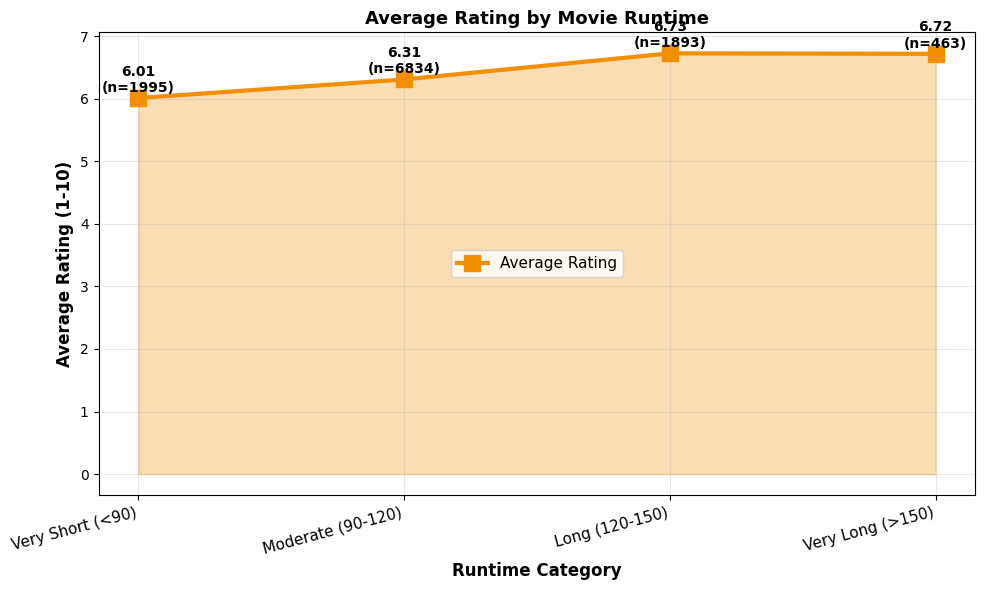

In [5]:
fig, axes = plt.subplots(1, figsize=(10, 6))

# Extract data for plotting
runtime_categories_plot = runtime_analysis_df['Runtime_Category'].values
avg_revenues = runtime_analysis_df['Avg_Revenue'].values
avg_ratings = runtime_analysis_df['Avg_Rating'].values
counts = runtime_analysis_df['Count'].values

# Color scheme
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']

# Average Rating by Runtime Category
axes.plot(range(len(runtime_categories_plot)), avg_ratings, 's-', 
            linewidth=3, markersize=12, color='#F18F01', label='Average Rating')
axes.fill_between(range(len(runtime_categories_plot)), avg_ratings, 
                    alpha=0.3, color='#F18F01')

# Add value labels and sample counts
for i, (rating, count) in enumerate(zip(avg_ratings, counts)):
    axes.text(i, rating + 0.05, f'{rating:.2f}\n(n={int(count)})', 
                ha='center', va='bottom', fontsize=10, fontweight='bold')

axes.set_xticks(range(len(runtime_categories_plot)))
axes.set_xticklabels(runtime_categories_plot, fontsize=11, rotation=15, ha='right')
axes.set_ylabel('Average Rating (1-10)', fontsize=12, fontweight='bold')
axes.set_xlabel('Runtime Category', fontsize=12, fontweight='bold')
axes.set_title('Average Rating by Movie Runtime', fontsize=13, fontweight='bold')
axes.grid(True, alpha=0.3)
axes.legend(fontsize=11, loc='best')

plt.tight_layout()
plt.show()

### Nhận xét: Phân tích Thời lượng Phim & Doanh thu

- Đồ thị cho thấy một xu hướng tăng dần về điểm đánh giá trung bình khi thời lượng phim kéo dài hơn. Cụ thể, điểm số tăng từ 6.01 cho phim ngắn ($<90$ phút) lên đến 6.75 cho phim dài ($120-150$ phút).

- Trái với giả thuyết ban đầu, nhóm phim có thời lượng vừa phải chỉ đạt mức điểm trung bình là 6.31. Mặc dù đây là nhóm có số lượng phim lớn nhất ($n=6834$), nhưng điểm số vẫn thấp hơn đáng kể so với các nhóm phim dài hơn.

- Các bộ phim có thời lượng trên 150 phút đạt điểm đánh giá rất cao (6.72), gần như tương đương với nhóm phim dài từ 120-150 phút (6.75). Điều này bác bỏ nhận định cho rằng phim quá dài sẽ làm khán giả cảm thấy mệt mỏi và đánh giá thấp hơn.

- Đồ thị cho thấy một sự "đi ngang" về điểm số sau khi đạt ngưỡng 120 phút. Sự chênh lệch điểm số giữa nhóm phim dài ($120-150$ phút) và rất dài ($>150$ phút) là không đáng kể (chỉ 0.03 điểm), cho thấy việc kéo dài phim quá 150 phút không mang lại thêm sự gia tăng đáng kể nào về mức độ hài lòng của khán giả.
